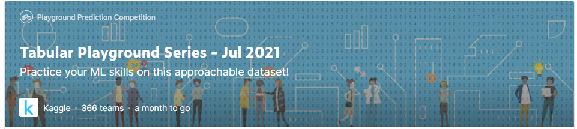

> このコンテストでは、基本的な気象情報（温度と湿度）と5つのセンサーの入力値に基づいて、時間の経過に伴う大気汚染測定値を予測します。
> 
> 予測する3つのターゲット値は、target_carbon_monoxide、target_benz、およびtarget_nitrogen_oxidesです。

> train.csv-気象データ、センサーデータ、3つのターゲットの値を含むトレーニングデータ<br>
> test.csv-train.csvと同じ形式ですが、ターゲット値はありません。 あなたの仕事は、これらの各ターゲットの値を予測することです。<br>
> sample_submission.csv-正しい形式のサンプル送信ファイル。

In [ ]:
# --- CSS STYLE ---
from IPython.core.display import HTML
def css_styling():
    styles = open("../input/competiongoal/archive/alerts.css", "r").read()
    return HTML("<style>"+styles+"</style>")
css_styling()


<div class="alert simple-alert"><font color="black">
🚀 <b>Competition Goal</b>： 時間の経過に伴う大気汚染測定値を予測します。
</div>

### できれれば、今回はAUTOMLを使わずになんとかしたい。前回、AUTOMLを使ったら考えなくなってしまったので。😂

In [ ]:
from pathlib import Path
import pandas as pd
import glob
import numpy as np
import pyarrow.parquet
import pyarrow as pa
import seaborn as sns
#import tqdm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import gc

import warnings
warnings.filterwarnings('ignore')

# 📌train.csv
2010/3/10～2011/1/1のデータ

In [ ]:
train = pd.read_csv('../input/tabular-playground-series-jul-2021/train.csv')
train

absolute_humidity：絶対湿度？<br>
relative_humidity：相対湿度<br>
deg_C:数字からして摂氏だと思う

## 🔨ヒートマップをとりあえず見てみる

In [ ]:
col=['deg_C','relative_humidity','absolute_humidity','sensor_1','sensor_2','sensor_3','sensor_4','sensor_5','target_carbon_monoxide','target_benzene','target_nitrogen_oxides']
plt.figure(figsize=(10,8))
sns.heatmap(train[col].corr(), vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.1)
plt.show()

・気温はあんまり関係なくて、senser1,2,4,5は正の関係、3は負の関係というのがわかります。<br>
・湿度もあまり関係ないように見えます。<br>
<u>→気温と湿度は説明変数から外そうかなあ</u><br>
・sensor2はtarget_benzeneと極めて高い関係がありますね。<br>
・target_carbon_monoxideは、sensor1,2,5と関係が高そうです。<br>
・target_nitrogen_oxidesはどのセンサーも微妙な関係というとこでしょうか。

### 📐target_carbon_monoxide 一酸化炭素

In [ ]:
train.target_carbon_monoxide.hist()

### 📐target_benzene ベンゼン

In [ ]:
train.target_benzene.hist()

### 📐target_nitrogen_oxides　窒素酸化物

In [ ]:
train.target_nitrogen_oxides.hist()

### 日ごとの３つの目的関数との関係(時間が結構かかる）

In [ ]:

targets = ["target_carbon_monoxide", "target_benzene", "target_nitrogen_oxides"]
target_names = ["Carbon monoxide", "Benzene", "Nitrogen oxides"]
fig, axs = plt.subplots(figsize=(16, 18), ncols=1, nrows=3, sharex=False)
plt.subplots_adjust(hspace = 0.3)

colors = ["red", "blue", "green"]

for i in [0, 1, 2]:
    axs[i].plot(train["date_time"], train[targets[i]], color=colors[i])
    axs[i].set_title(f"{target_names[i]} (target #{i+1}) ", fontsize=20, pad=5)
    axs[i].set_ylabel(f"{target_names[i]} level", fontsize=14, labelpad=5)
    axs[i].set_xlabel("Date", fontsize=14, labelpad=5)
    axs[i].grid(axis="both")

plt.show();


# 📌test.csv
2011/1/1～2011/4/4のデータを予測する。随分古いデータを予測するんですね。

In [ ]:
test = pd.read_csv('../input/tabular-playground-series-jul-2021/test.csv')
test

# 📌sample_submission.csv
目的関数は、target_carbon_monoxide	target_benzene	target_nitrogen_oxidesの３つですね。
英語だとわかりませんが、訳すと一酸化炭素、ベンゼン、窒素酸化物となりました。

In [ ]:
sub = pd.read_csv('../input/tabular-playground-series-jul-2021/sample_submission.csv')
sub

## 📁評価は対数平均二乗誤差（RMSLE)だそうです。

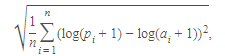

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

### 特徴量追加

train['date_time'] = pd.to_datetime(train['date_time'])
train['year'] = train['date_time'].dt.year
train['month'] = train['date_time'].dt.month
train['week'] = train['date_time'].dt.week
train['day'] = train['date_time'].dt.day
train['dayofweek'] = train['date_time'].dt.dayofweek
train['time'] = train['date_time'].dt.date - train['date_time'].dt.date.min()
train['hour'] = train['date_time'].dt.hour
train['time'] = train['time'].apply(lambda x : x.days)
train

test['date_time'] = pd.to_datetime(test['date_time'])
test['year'] = test['date_time'].dt.year
test['month'] = test['date_time'].dt.month
test['week'] = test['date_time'].dt.week
test['day'] = test['date_time'].dt.day
test['dayofweek'] = test['date_time'].dt.dayofweek
test['time'] = test['date_time'].dt.date - test['date_time'].dt.date.min()
test['hour'] = test['date_time'].dt.hour
test['time'] = test['time'].apply(lambda x : x.days)
test

In [ ]:
train['SMC'] = (train['absolute_humidity'] * 100) / train['relative_humidity']
train['Dew_Point'] = 243.12*(np.log(train['relative_humidity'] * 0.01) + (17.62 * train['deg_C'])/(243.12+train['deg_C']))/(17.62-(np.log(train['relative_humidity'] * 0.01)+17.62*train['deg_C']/(243.12+train['deg_C'])))

In [ ]:
test['SMC'] = (test['absolute_humidity'] * 100) / test['relative_humidity']
test['Dew_Point'] = 243.12*(np.log(test['relative_humidity'] * 0.01) + (17.62 * test['deg_C'])/(243.12+test['deg_C']))/(17.62-(np.log(test['relative_humidity'] * 0.01)+17.62*test['deg_C']/(243.12+test['deg_C'])))

In [ ]:
train

In [ ]:
target = train[['target_carbon_monoxide','target_benzene','target_nitrogen_oxides']]
train = train.drop(['target_carbon_monoxide','target_benzene','target_nitrogen_oxides','date_time','deg_C'],axis=1)

In [ ]:
test = test.drop(['date_time','deg_C'],axis=1)

In [ ]:
 X_train, X_test, y_train, y_test =train_test_split(train, target, test_size=0.3, random_state=42)

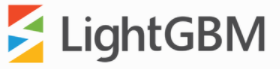

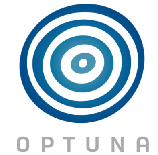

どうもうまく動きません。この凄まじいワーニングメッセージはどうにかならないものなんですかね。<br>
検索してもでてきませんでした。<br>
そういえば、OPTUNA使ってスコアが改善したことは今のところありませんでしたが、今回は少しよくなりました。

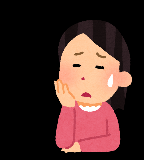

In [ ]:
import optuna 
import optuna.integration.lightgbm as lgbo
import lightgbm as lgb

params = { 'objective': 'mae', 'metric': 'mae' } #binary_error(正答率)
x_train, x_test, y_train, y_test = train_test_split(train, target['target_carbon_monoxide'], test_size=0.3, random_state=42)
lgb_train1 = lgb.Dataset(X_train, y_train)
lgb_valid1 = lgb.Dataset(X_test, y_test)
model1 = lgbo.train(params, lgb_train1, valid_sets=[lgb_valid1], verbose_eval=100)
model1.params

x_train, x_test, y_train, y_test = train_test_split(train, target['target_benzene'], test_size=0.3, random_state=42)
lgb_train2 = lgb.Dataset(X_train, y_train)
lgb_valid2 = lgb.Dataset(X_test, y_test)
model2 = lgbo.train(params, lgb_train2, valid_sets=[lgb_valid2], verbose_eval=100)
model2.params

x_train, x_test, y_train, y_test = train_test_split(train, target['target_nitrogen_oxides'], test_size=0.3, random_state=42)
lgb_train3 = lgb.Dataset(X_train, y_train)
lgb_valid3 = lgb.Dataset(X_test, y_test)
model3 = lgbo.train(params, lgb_train3, valid_sets=[lgb_valid3], verbose_eval=100)
model3.params

In [ ]:
import lightgbm as lgb
params={'objective': 'mae',
 'metric': 'mae',
 'feature_pre_filter': False,
 'lambda_l1': 4.670375258649679e-05,
 'lambda_l2': 0.012532552526253581,
 'num_leaves': 192,
 'feature_fraction': 0.8999999999999999,
 'bagging_fraction': 0.7664304386463259,
 'bagging_freq': 4,
 'min_child_samples': 20,
 'num_iterations': 1000,
 'early_stopping_round': None}
params["learning_rate"] = 0.01
params["early_stopping_round"] = 50  
params["max_depth"] = 11
#best_lgb_params['min_data_in_leaf'] = 9
params["num_iterations"] = 800

model1.params['learning_rate'] = 0.01
model1.params["num_iterations"] = 2000
model1.params["early_stopping_round"] = 50 
model2.params['learning_rate'] = 0.01
model2.params["num_iterations"] = 2000
model2.params["early_stopping_round"] = 50 
model3.params['learning_rate'] = 0.01
model3.params["num_iterations"] = 2000
model3.params["early_stopping_round"] = 50 

In [ ]:
model1.params

In [ ]:
model2.params

In [ ]:
model3.params

In [ ]:
model1 = lgb.train(model1.params,lgb_train1,valid_sets=[lgb_valid1] ,verbose_eval=100)
model2 = lgb.train(model2.params,lgb_train2,valid_sets=[lgb_valid2] ,verbose_eval=100)
model3 = lgb.train(model3.params,lgb_train3,valid_sets=[lgb_valid3] ,verbose_eval=100)

### 他クラスLightGBM 一旦コメント

from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb

params={'learning_rate': 0.07,
        'objective':'mae', 
        'metric':'mae',
        'lambda_l1': 4.670375258649679e-05,
        'lambda_l2': 0.012532552526253581,
        'num_leaves': 192,
        'feature_fraction': 0.8999999999999999,
        'bagging_fraction': 0.7664304386463259,
        'bagging_freq': 4,
        'min_child_samples': 20,
        'verbose': 1,
        'bagging_fraction': 0.8,
        'feature_fraction': 0.8,
        'max_depth':30
       }
reg = MultiOutputRegressor(lgb.LGBMRegressor(**params, n_estimators=1000))

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)


RMSE=np.sqrt(mean_squared_error(y_test, y_pred))
RMSE

y_pred = reg.predict(test)

In [ ]:
y_pred1 = model1.predict(test)
y_pred2 = model2.predict(test)
y_pred3 = model3.predict(test)

In [ ]:
sub.target_carbon_monoxide = y_pred1
sub.target_benzene = y_pred2
sub.target_nitrogen_oxides =y_pred3

# いじればイジるほどスコアが悪化していきます。
# 初心者あるあるなんですかね。

In [ ]:
sub.to_csv('submission.csv',index=False)
sub